# Домашнее задание 3

## Задание

Реализовать алгоритм Кэнни.

Алгоритм Кэнни:
1. Сгладить исходное изображение гауссовым фильтром.
1. Сформировать изображения модуля и направления градиента.
1. Применить подавление немаксимальных точек к изображению модуля градиента.
1. Выполнить преобразование с двойным порогом и анализ связности для обнаружения и связывания контуров.

Детальное описание было на третьей лекции (из книги Гонсалес, Вудс "Цифровая обработка изображений").

Ожидается, что вы будете действовать в соответствии с шаблоном ниже, поэтому если будете писать по-своему, обоснуйте, пожалуйста.

In [1]:
import matplotlib.pyplot as plt
import skimage
import skimage.filters
import skimage.feature
from skimage import data
import numpy as np
import cv2
from pprint import pprint
from scipy import ndimage
from sklearn.preprocessing import normalize

def imshow(image, ax=None, title=None, **kwargs):
  if ax is None:
    ax = plt
  ax.imshow(image, **kwargs)
  if title is not None:
    ax.set_title(title)
  ax.axis('off');

def imshow_images(images, titles=None, ncols=None, nrows=None, **kwargs):
  if ncols is None and nrows is None:
    ncols = len(images)
    nrows = 1
  elif ncols is None or nrows is None:
    if ncols is None: ncols = 1
    if nrows is None: nrows = 1
  fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 10))
  for i, image in enumerate(images):
    title = None
    if titles is not None:
      title = titles[i]
    imshow(image, axes[i], title, **kwargs)
  plt.show()

In [2]:
def get_gradient(image):
    im=image
    im = im.astype('float')
    Gx = ndimage.sobel(im, 0)  
    Gy = ndimage.sobel(im, 1)  
    G = np.hypot(Gx, Gy)  
    G *= 255.0 / np.max(G)
    angle_grad = np.arctan2(Gy,Gx)
      
    return G, angle_grad

In [80]:
def get_local_maxima(G, angle_grad):
    x, y = G.shape
    ans_matrix = np.zeros((x,y),dtype=np.int32)
    angle = angle_grad*180. / np.pi
    angle[angle<0] += 180
    
    for i in range(1,x-1):
        for j in range(1,y-1):
            try:
                pix1=255 
                pix2=255 
                
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180): # контур под углом 0    
                    pix1 = G[i+1, j]
                    pix2 = G[i-1, j]
               
                elif (22.5 <= angle[i,j] < 67.5): # контур под углом 45
                    pix1 = G[i-1, j-1]
                    pix2 = G[i+1, j+1]
                
                elif (67.5 <= angle[i,j] < 112.5): # контур под углом 90 
                    pix1 = G[i, j+1]
                    pix2 = G[i, j-1]
                
                elif (112.5 <= angle[i,j] < 157.5): # контур под углом 135
                    pix1 = G[i+1, j-1]
                    pix2 = G[i-1, j+1]

                if (G[i,j] >= pix1) and (G[i,j] >= pix2): #Проверяем яркость пикселей. Если значение меньше, чем хотя бы у одного из соседей, то 0
                    ans_matrix[i,j] = G[i,j]
                else:
                    ans_matrix[i,j] = 0 
                    
            except IndexError as e:
                pass

    return ans_matrix

In [81]:
def two_threshold(ans_matrix, angle_grad, low_T, high_T):
    x, y = ans_matrix.shape
    res = ans_matrix.copy() 
    res_1=ans_matrix.copy()   
    res_2=ans_matrix.copy() 
    res_3=ans_matrix.copy()  
    res_4=ans_matrix.copy() 
    res_final=np.zeros((x,y), dtype=np.int32)
    weak = np.int32(50)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(ans_matrix >= high_T)
    zeros_i, zeros_j = np.where(ans_matrix < low_T)
    
    weak_i, weak_j = np.where((ans_matrix < high_T) & (ans_matrix >= low_T))
    
    res[strong_i, strong_j] = strong
    res[zeros_i, zeros_j] = 0.
    res[weak_i, weak_j] = weak
    
    res_1[strong_i, strong_j] = strong
    res_2[strong_i, strong_j] = strong
    res_3[strong_i, strong_j] = strong
    res_4[strong_i, strong_j] = strong
     
    for i in range(1, x-1): #слева направо сверху вниз
        for j in range(1, y-1):
            if (res[i,j] == weak):
                try:
                    if ((res[i-1,j-1] == strong) or (res[i-1,j] == strong) or (res[i-1,j+1] == strong) or
                        (res[i,j-1] == strong) or (res[i,j+1] == strong) or (res[i+1,j-1] == strong) or
                        (res[i+1,j]==strong) or (res[i+1,j+1] == strong)):
                        res[i, j] = strong
                            
                    else:
                        res_1[i, j] = 0
                except IndexError as e:
                    pass
                
    for i in range(x-1,0,-1 ):
        for j in range(y-1, 0,-1):
            if (res[i,j] == weak):
                try:
                    if ((res[i-1,j-1] == strong) or (res[i-1,j] == strong) or (res[i-1,j+1] == strong) or
                        (res[i,j-1] == strong) or (res[i,j+1] == strong) or (res[i+1,j-1] == strong) or
                        (res[i+1,j]==strong) or (res[i+1,j+1] == strong)):
                        res[i, j] = strong
                            
                    else:
                        res_2[i, j] = 0
                except IndexError as e:
                    pass

    for i in range(1,x-1 ):
        for j in range(y-1, 0,-1):
            if (res[i,j] == weak):
                try:
                    if ((res[i-1,j-1] == strong) or (res[i-1,j] == strong) or (res[i-1,j+1] == strong) or
                        (res[i,j-1] == strong) or (res[i,j+1] == strong) or (res[i+1,j-1] == strong) or
                        (res[i+1,j]==strong) or (res[i+1,j+1] == strong)):
                        res[i, j] = strong
                            
                    else:
                        res_3[i, j] = 0
                except IndexError as e:
                    pass

    for i in range(x-1,0,-1 ):
        for j in range(1, y-1):
            if (res[i,j] == weak):
                try:
                    if ((res[i-1,j-1] == strong) or (res[i-1,j] == strong) or (res[i-1,j+1] == strong) or
                        (res[i,j-1] == strong) or (res[i,j+1] == strong) or (res[i+1,j-1] == strong) or
                        (res[i+1,j]==strong) or (res[i+1,j+1] == strong)):
                        res[i, j] = strong
                            
                    else:
                        res_4[i, j] = 0
                except IndexError as e:
                    pass


    res_final = res_1 +res_2+res_3+res_4
    res_final[res_final > 255] = 255
    
    
    return res_final

In [86]:
def canny(image, gaussian_sigma, low_T, high_T):
  blur_image = skimage.filters.gaussian(image, sigma=gaussian_sigma)

  abs_grad, angle_grad = get_gradient(blur_image)
  abs_grad = get_local_maxima(abs_grad, angle_grad)
  abs_grad = two_threshold(abs_grad, angle_grad, low_T, high_T)
  return abs_grad

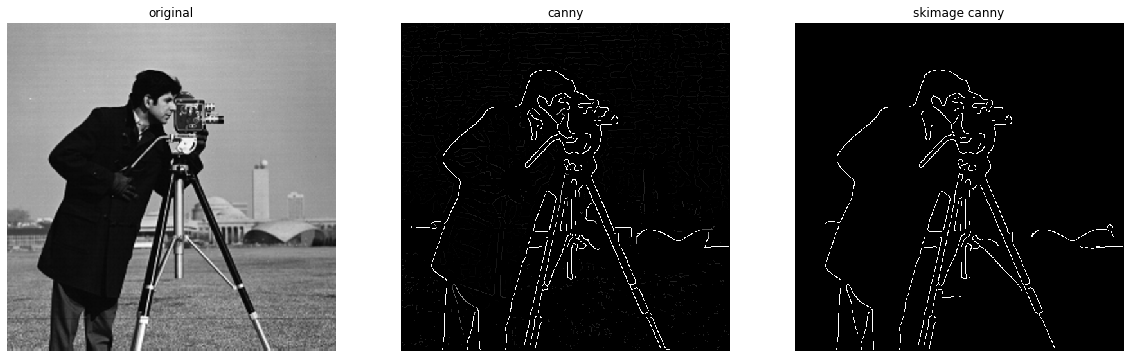

In [87]:
# для тестов

image = data.camera()
sigma = 3.0
low_T = 10
high_T = 100
our_canny = canny(image, sigma, low_T, high_T)
sk_canny = skimage.feature.canny(image, sigma=sigma, low_threshold=low_T, high_threshold=high_T)
imshow_images([image, our_canny, sk_canny], titles=['original', 'canny', 'skimage canny'], cmap='gray')

print()